In [186]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": "white"})
from datetime import date

### Exploratory Data Analysis

In [36]:
# Get the historical data for Microsoft as an example

msft = yf.Ticker("MSFT") 
stock_data_msft_example = msft.history(period="1mo")

# show meta information about the history (requires history() to be called first)
msft.history_metadata
# get all stock info : msft.info

{'currency': 'USD',
 'symbol': 'MSFT',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 511108200,
 'regularMarketTime': 1688997695,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 330.07,
 'chartPreviousClose': 326.79,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1688976000,
   'end': 1688995800,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1688995800,
   'end': 1689019200,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1689019200,
   'end': 1689033600,
   'gmtoffset': -14400}},
 'dataGranularity': '1d',
 'range': '1mo',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  '10y',
  'ytd',
  'max']}

In [5]:
# show actions (dividends, splits, capital gains)
msft.actions
msft.dividends
msft.splits
msft.capital_gains  # only for mutual funds & etfs

# show share count
msft.get_shares_full(start="2022-01-01", end=None)

# show financials:
# - income statement
msft.income_stmt
msft.quarterly_income_stmt
# - balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet
# - cash flow statement
msft.cashflow
msft.quarterly_cashflow
# see `Ticker.get_income_stmt()` for more options

# show holders
msft.major_holders
msft.institutional_holders
msft.mutualfund_holders

# Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
msft.earnings_dates

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# show news
msft.news

# get option chain for specific expiration
opt = msft.option_chain('2023-07-14')
# data available via: opt.calls, opt.puts

In [75]:
stocks = ["AAPL", "MSFT", "AEE", "AIG", "ADBE", "NVDA", "META",
          "ROST", "JD", "PDD", "DDOG", "GOOGL", "AMZN", "SPY", "NDAQ"]

# Get the data for the stocks
today = date.today()
stock_data = yf.download(stocks, start="2022-07-10", end=today)

[*********************100%***********************]  15 of 15 completed


In [126]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

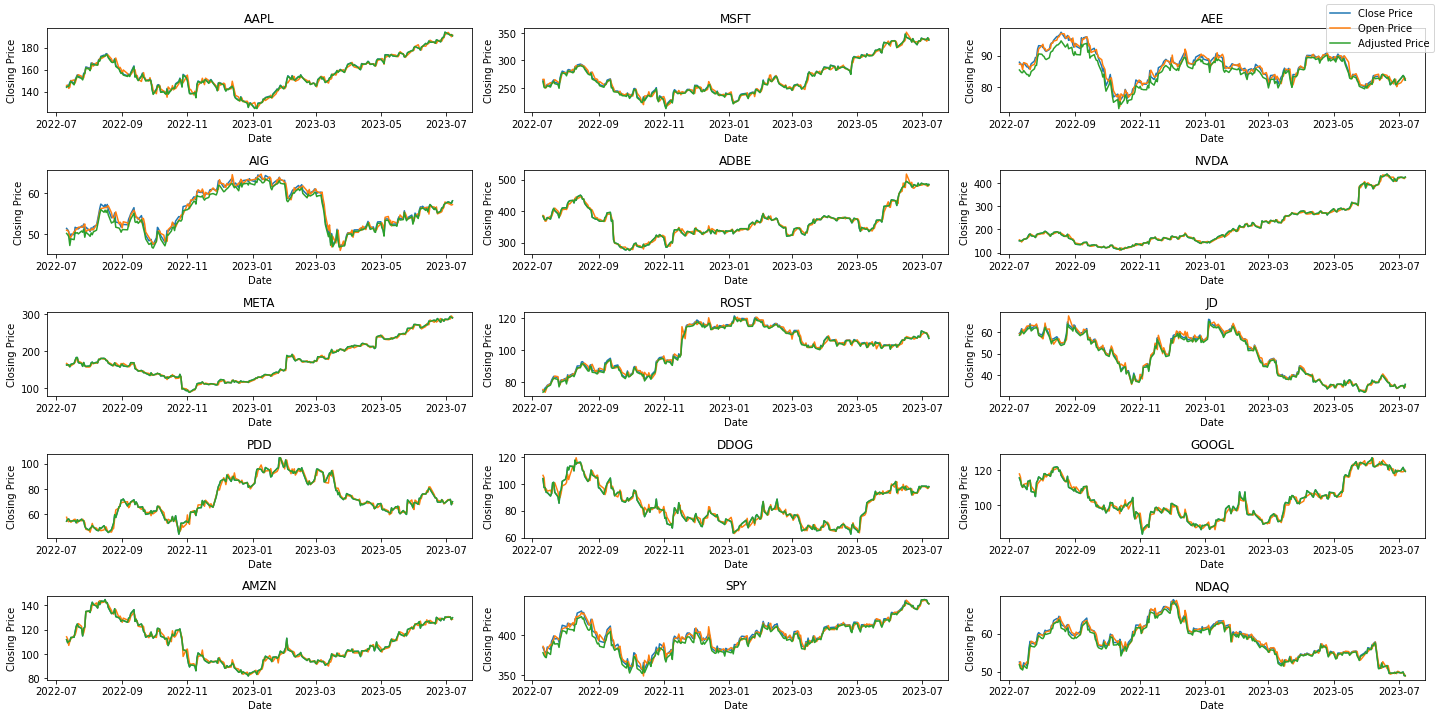

In [77]:
f = plt.figure(figsize=(20, 10))
for i, stock in enumerate(stocks) :
    plt.subplot(5, 3, i + 1)
    plt.plot(stock_data["Close"][stock], label='Close Price')
    plt.plot(stock_data["Open"][stock], label='Open Price')
    plt.plot(stock_data["Adj Close"][stock], label = "Adjusted Price")
    plt.title(stock)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if i==0 : f.legend()

plt.tight_layout()
plt.show()

We can see that almost all stocks have the same upwards tendency in all of 3 the prices. The only exception is the NASDAQ index. However, the variations are heavy and abrupt.

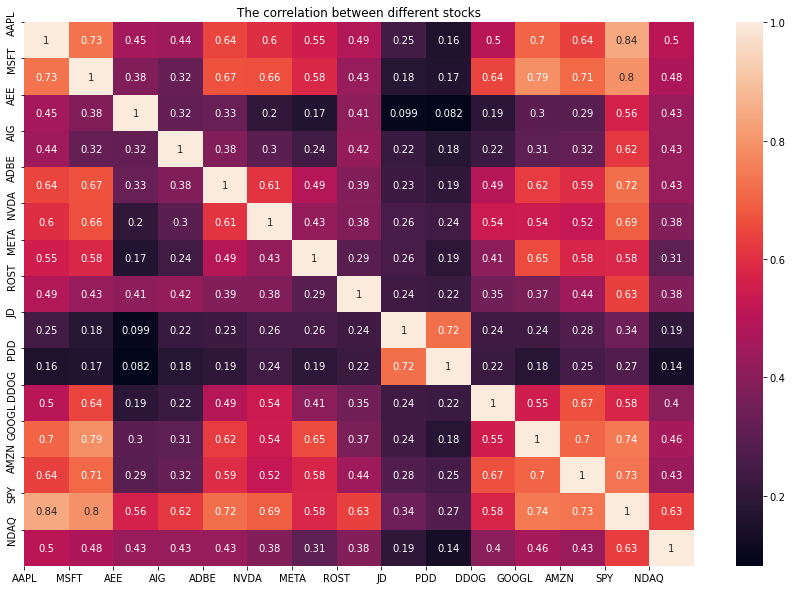

In [87]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat([stock_data['Adj Close'][stock].pct_change() for stock in stocks], axis=1).corr(), annot=True)
plt.yticks(range(len(stocks)), stocks)
plt.xticks(range(len(stocks)), stocks)
plt.title("The correlation between different stocks")
plt.show()

The observed results and correlations between stocks seem coherent, and we can assume that there are no anomalies in the data we have.

### Clustering to construct a diversified Portfolio

In [148]:
all_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'INTC', 'NVDA', 'ADBE',
               'PYPL', 'CSCO', 'NFLX', 'PEP', 'TSLA', 'CMCSA', 'AMGN', 'COST', 'TMUS', 'AVGO',
               'TXN', 'CHTR', 'QCOM', 'GILD', 'SBUX', 'INTU', 'VRTX', 'MDLZ', 'ISRG', 'FISV',
               'BKNG', 'ADP', 'REGN', 'ATVI', 'AMD', 'JD', 'MU', 'AMAT', 'ILMN', 'ADSK',
               'CSX', 'MELI', 'LRCX', 'ADI', 'ZM', 'BIIB', 'EA', 'KHC', 'WBA', 'LULU',
               'EBAY', 'MNST', 'DXCM', 'EXC', 'BIDU', 'XEL', 'WDAY', 'DOCU', 'SPLK', 'ORLY',
               'NXPI', 'CTSH', 'KLAC', 'SNPS', 'SGEN', 'ASML', 'IDXX', 'CSGP', 'CTAS', 'VRSK',
               'MAR', 'CDNS', 'PAYX', 'MCHP', 'SIRI', 'ANSS', 'VRSN', 'FAST', 'BMRN',
               'INCY','DLTR', 'SWKS', 'ALGN', 'CPRT', 'TTWO', 'CDW',
               'CHKP', 'WDC', 'ULTA', 'NTAP', 'FOXA', 'LBTYK']

all_stock_data = yf.download(all_stocks, start="2013-07-10", end=today)

[*********************100%***********************]  90 of 90 completed


In [150]:
index_ticker = "SPY"
index = yf.Ticker(index_ticker)
index_history = index.history(period="1y")
index_adj_close = index_history["Close"]

#Create a dataset to fill 
data = pd.DataFrame(columns=["Stock", "Annualized Return on Equity",
                                "Annualized Volatility on Equity", 
                                "Sharpe Ratio", "Correlation"])

for stock_ticker in all_stocks :
    
    # Extract the adjusted close prices for both
    stock = yf.Ticker(stock_ticker)
    history = stock.history(period="1y")

    stock_adj_close = history["Close"]
    daily_returns = history["Close"].pct_change()
    
    # Calculate annualized return on equity (daily returns)
    annualized_return_on_equity = daily_returns.mean() * 252
    
    # Calculate annualized volatility on equity (daily returns)
    annualized_volatility_on_equity = daily_returns.std() * np.sqrt(252)
    
    # Calculate Sharpe Ratio
    risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
    sharpe_ratio = (annualized_return_on_equity - risk_free_rate) / annualized_volatility_on_equity
    
    # Calculate daily change in price
    daily_change = stock_adj_close.diff()
    
    # Calculate the correlation with the S&P 500 index
    correlation = stock_adj_close.corr(index_adj_close)
    
    # create a line in a dataset with the computed variables
    data.loc[len(data)] = [stock_ticker, annualized_return_on_equity, 
                           annualized_volatility_on_equity, sharpe_ratio,
                           correlation]
    

In [154]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Sharpe Ratio,Correlation,Cluster
0,AAPL,0.313646,0.294728,0.996327,0.839005,1
1,MSFT,0.285438,0.322921,0.821990,0.878242,1
2,AMZN,0.212729,0.414048,0.465475,0.385350,1
3,GOOGL,0.072973,0.361016,0.146734,0.692395,1
4,GOOG,0.072112,0.364963,0.142788,0.689427,1


C:\Users\IQBI Hamza\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\IQBI Hamza\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Clusters of stocks')

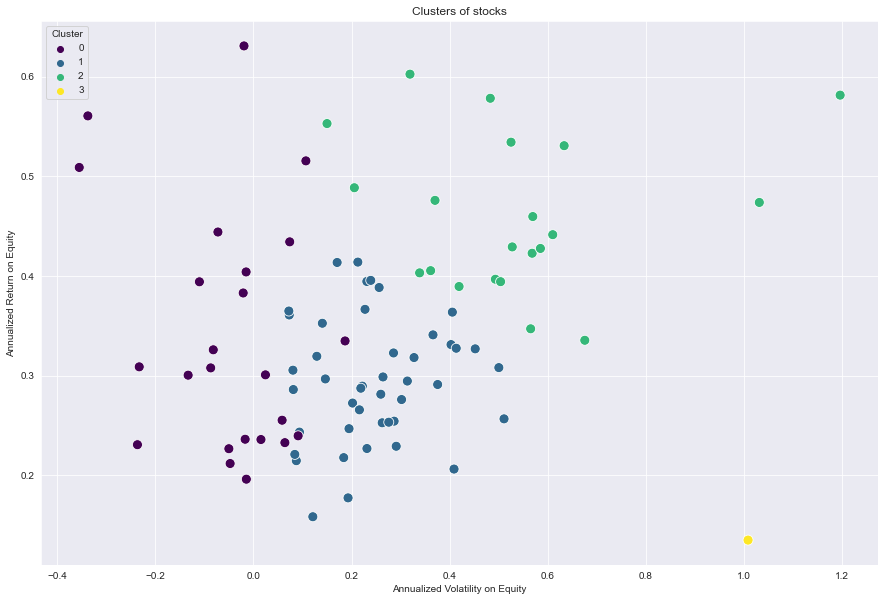

In [187]:
# cluster the stocks based on the computed features

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a dataset with the features we want to cluster
X = data[["Annualized Return on Equity", "Annualized Volatility on Equity",
            "Sharpe Ratio", "Correlation"]]
X = StandardScaler().fit_transform(X)

# Create a KMeans object with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
# Fit and predict using our model   
clusters = kmeans.fit_predict(X)

# Add the clusters to our dataset
data["Cluster"] = clusters

# Plot the clusters   
plt.figure(figsize=(15, 10))
# plot with seaborn
sns.scatterplot(data=data, x="Annualized Return on Equity", y="Annualized Volatility on Equity", hue="Cluster", s=100, palette="viridis")
plt.xlabel("Annualized Volatility on Equity")
plt.ylabel("Annualized Return on Equity")
plt.title("Clusters of stocks")

In [188]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Sharpe Ratio,Correlation,Cluster
0,AAPL,0.313646,0.294728,0.996327,0.839005,1
1,MSFT,0.285438,0.322921,0.821990,0.878242,1
2,AMZN,0.212729,0.414048,0.465475,0.385350,1
3,GOOGL,0.072973,0.361016,0.146734,0.692395,1
4,GOOG,0.072112,0.364963,0.142788,0.689427,1


In [189]:
# Group the clusters
cluster_0 = data[data["Cluster"]==0]
cluster_1 = data[data["Cluster"]==1]
cluster_2 = data[data["Cluster"]==2]
cluster_3 = data[data["Cluster"]==3]

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_

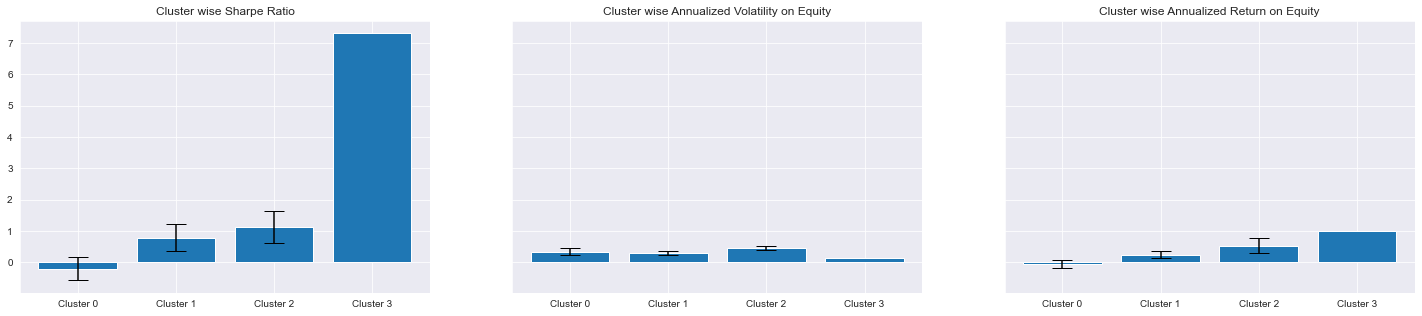

In [202]:
selected_features = ["Sharpe Ratio", "Annualized Volatility on Equity", "Annualized Return on Equity"]
f, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
for ax, feature in zip(axes, selected_features) :
        mean_feature_0 = cluster_0[feature].mean()
        mean_feature_1 = cluster_1[feature].mean()
        mean_feature_2 = cluster_2[feature].mean()
        mean_feature_3 = cluster_3[feature].mean()
        
        std_feature_0 = cluster_0[feature].std()
        std_feature_1 = cluster_1[feature].std()
        std_feature_2 = cluster_2[feature].std()
        std_feature_3 = cluster_3[feature].std()
        
        ax.bar(x=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"],
                height=[mean_feature_0, mean_feature_1, mean_feature_2, mean_feature_3],
                yerr=[std_feature_0, std_feature_1, std_feature_2, std_feature_3],
                capsize=10)
        ax.set_title("Cluster wise " + feature)